In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import keras_tuner as kt
import sys
from pathlib import Path
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

root_path = str(Path.cwd().parent)
if root_path not in sys.path:
    sys.path.append(root_path)
from utils import criar_sequencias  # noqa: E402
from utils import construcao_modelo  # noqa: E402

pd.set_option("display.max_columns", None)

In [146]:
df_model = pd.read_parquet("../arquivos_parquet/dados_base.parquet")
df_model = df_model.sort_index(ascending=True)
df_model_LSTM = df_model[["Close", "Var%"]]
df_model_LSTM

,Close,Var%
Date,,
2023-01-02,14.359387,0.000000
2023-01-03,14.084915,-1.911448
2023-01-04,14.098303,0.095050
2023-01-05,14.513355,2.943988
2023-01-06,14.700802,1.291546
...,...,...
2026-02-09,44.750000,3.015657
2026-02-10,44.889999,0.312848
2026-02-11,45.730000,1.871241


In [147]:
seed_value = 42
WINDOW_SIZE = 15

python_random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [148]:
split_idx = int(len(df_model_LSTM) * 0.8)
train_df = df_model_LSTM.iloc[:split_idx]
test_df = df_model_LSTM.iloc[split_idx:]

In [149]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [150]:
X_train, y_train = criar_sequencias(train_scaled, WINDOW_SIZE)
X_test, y_test = criar_sequencias(test_scaled, WINDOW_SIZE)

In [151]:
print(f"Formato dos dados de treino: {X_train.shape}")
print(f"Formato dos dados de teste: {X_test.shape}")

Formato dos dados de treino: (609, 15, 2)
Formato dos dados de teste: (141, 15, 2)


In [152]:
early_stop = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

tuner = kt.Hyperband(
    construcao_modelo,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="tuner_results",
    project_name="itub3_optimization",
)

tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],  # Usando o seu early_stop configurado
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Reloading Tuner from tuner_results\itub3_optimization\tuner0.json


In [153]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 15, 96)         │        38,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         2,425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,579 (447.57 KB)

 Trainable params: 114,579 (447.57 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0353 - mae: 0.2011 - val_loss: 0.0949 - val_mae: 0.4119
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0035 - mae: 0.0654 - val_loss: 0.0077 - val_mae: 0.0843
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - mae: 0.0492 - val_loss: 0.0082 - val_mae: 0.0864
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - mae: 0.0412 - val_loss: 0.0083 - val_mae: 0.0919
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - mae: 0.0387 - val_loss: 0.0111 - val_mae: 0.1155
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013 - mae: 0.0387 - val_loss: 0.0065 - val_mae: 0.0795
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - mae: 0.0370 - val_loss: 0.0088 - val_mae: 0.1034
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - mae: 0.0362 - val_loss: 0.0053 - val_mae: 0.0724
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

In [155]:
# 1. Fazendo as previsões no conjunto de teste
y_pred = model.predict(X_test)

# 2. Preparando para a inversão do scaling
# matrizes temporárias com o mesmo número de colunas do treino (2)
y_test_unscaled = np.zeros((len(y_test), 2))
y_pred_unscaled = np.zeros((len(y_pred), 2))

# Colocamos nossos valores na primeira coluna (índice 0, que era o 'Close')
y_test_unscaled[:, 0] = y_test
y_pred_unscaled[:, 0] = y_pred.flatten()

# 3. Invertendo a transformação
y_test_final = scaler.inverse_transform(y_test_unscaled)[:, 0]
y_pred_final = scaler.inverse_transform(y_pred_unscaled)[:, 0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


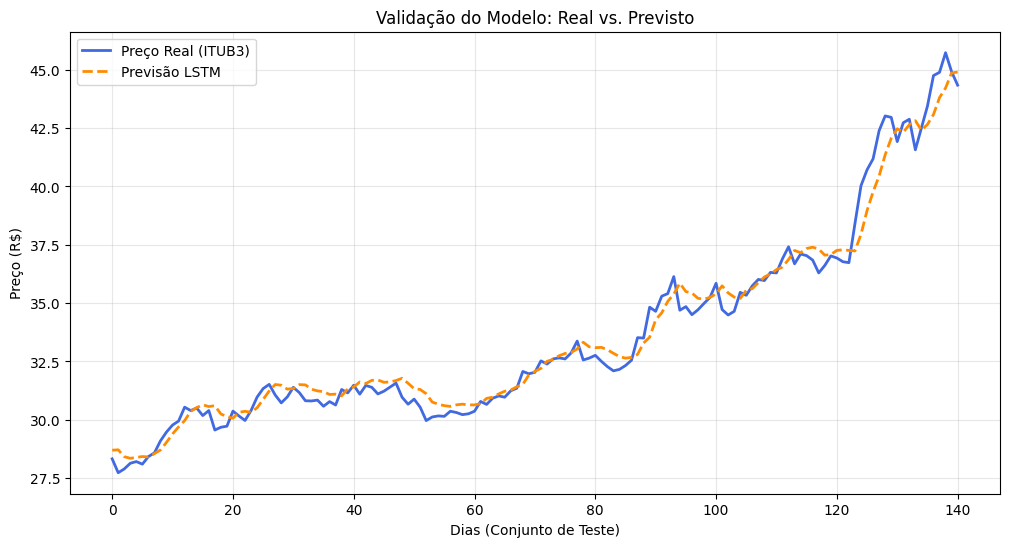

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(
    y_test_final, label="Preço Real (ITUB3)", color="royalblue", linewidth=2
)
plt.plot(
    y_pred_final,
    label="Previsão LSTM",
    color="darkorange",
    linestyle="--",
    linewidth=2,
)
plt.title("Validação do Modelo: Real vs. Previsto")
plt.xlabel("Dias (Conjunto de Teste)")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [157]:
mae = mean_absolute_error(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mape = np.mean(np.abs((y_test_final - y_pred_final) / y_test_final)) * 100

print(f"MAE: R$ {mae:.2f}")
print(f"RMSE: R$ {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: R$ 0.48
RMSE: R$ 0.63
MAPE: 1.40%


In [158]:
last_window = test_scaled[-WINDOW_SIZE:].copy()
current_batch = last_window.reshape((1, WINDOW_SIZE, 2))

forecast_5d = []

In [159]:
# --- 1. Preparação das Datas (Baseado no DataFrame original) ---
# Pegamos a última data disponível no índice do df_model_LSTM
ultima_data = df_model_LSTM.index.max()
datas_projecao = pd.date_range(
    start=ultima_data + pd.Timedelta(days=1), periods=5, freq="B"
)

# 2. Loop de Previsão Recursiva para 5 passos
for _ in range(5):
    # Predição do próximo ponto (escala 0-1)
    current_pred = model.predict(current_batch, verbose=0)[0]
    forecast_5d.append(current_pred)

    # --- Atualização da Janela (Feature Engineering Dinâmica) ---
    last_price = current_batch[0, -1, 0]
    new_price = current_pred[0]

    # Calculamos a Var% para manter o padrão multivariado
    new_var = (new_price - last_price) / last_price if last_price != 0 else 0

    # Monta a nova linha e desliza a janela
    new_entry = np.array([new_price, new_var]).reshape(1, 1, 2)
    current_batch = np.append(current_batch[:, 1:, :], new_entry, axis=1)

# 3. Inversão do Scaling para Reais (R$)
forecast_unscaled = np.zeros((5, 2))
forecast_unscaled[:, 0] = np.array(forecast_5d).flatten()
# Usamos o scaler que você já foi definido no treinamento
forecast_final = scaler.inverse_transform(forecast_unscaled)[:, 0]

# --- 4. Exibição Organizada com Datas ---
print(
    f"""Projeção ITUB3 para os próximos 5 dias úteis
    (Iniciando em {datas_projecao[0].strftime('%d/%m/%Y')}):"""
)
print("-" * 50)
for data, preco in zip(datas_projecao, forecast_final):
    print(
        f"{data.strftime('%d/%m/%Y')} ({data.strftime('%a')}): R$ {preco:.2f}"
    )
print("-" * 50)

Projeção ITUB3 para os próximos 5 dias úteis
    (Iniciando em 16/02/2026):
--------------------------------------------------
16/02/2026 (Mon): R$ 44.78
17/02/2026 (Tue): R$ 44.29
18/02/2026 (Wed): R$ 43.67
19/02/2026 (Thu): R$ 42.98
20/02/2026 (Fri): R$ 42.27
--------------------------------------------------
